In [2]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import py_compile
py_compile.compile('process.py')
from process import *

# load in data
data_path='../data_extraction/data/'

cohort = pd.read_table(data_path+'cohort.tsv')

cohort.ix[cohort.age > 90, 'age']=90

urine = pd.read_csv(data_path+'urine.csv')
urine = urine.loc[urine['value'] < 5000]

maps = pd.read_csv(data_path+'map.csv')
creatinine = pd.read_csv(data_path+'creatinine.csv')
admission_creatinine = pd.read_csv(data_path+'admission_creatinine.csv')


In [3]:
# Interpolate the weights

cohort.set_index('icustay_id', inplace=True)

cohort = interpolateweights(cohort)

# Compute the urine blocks
aki_urine = calculateurineaki(urine, cohort)
cohort = pd.read_table(data_path+'cohort.tsv')

In [4]:
# Get ethnicities 
eth = geteth(cohort)

In [5]:
# clean the lactate
cohort = cohort.loc[cohort['max_lactate'] < 100]
cohort = cohort[pd.notnull(cohort['max_lactate'])]

In [6]:
# Get map features 
map_cutoffs = np.append(np.arange(30,100,10),200)
mean_maps, min_maps, map_fracs = getmapfeatures(maps,map_cutoffs)

Fraction of hours missing MAP values: 0.0727082162255


In [7]:
# Process creatinine values and calculate aki 
creat_summary = analyzecreatinine(creatinine, admission_creatinine)

In [8]:
# Get the logistic regression data
lr_data, aki_dataset, non_aki_dataset = getlrdata(cohort, eth, min_maps, map_fracs, creat_summary, aki_urine)

In [9]:
# Summarize results

#AKI
print "------------------------------- AKI Patients -------------------------------"
print "============================================================================"
get_summary(aki_dataset)

#Non-AKI
print "----------------------------- Non-AKI Patients -----------------------------"
print "============================================================================"
get_summary(non_aki_dataset)

#Overall
print "------------------------------- All Patients -------------------------------"
print "============================================================================"
get_summary(lr_data)

------------------------------- AKI Patients -------------------------------
               age          los  max_lactate    vaso_frac      min_map
count  2942.000000  2942.000000  2942.000000  2942.000000  2942.000000
mean     76.697727    12.980428     3.340445     0.159124    46.299796
std      55.131962    11.297079     2.823739     0.228874     9.410704
min      18.340391     3.001000     0.500000     0.000000    30.333300
25%      54.343115     5.344375     1.600000     0.000000    39.000000
50%      67.386841     9.314600     2.400000     0.042935    46.000000
75%      78.344660    16.317650     4.000000     0.243792    52.000000
max     309.777981   173.072500    27.700000     0.995077   102.000000

gender:
M    1502
F    1440
dtype: int64

M    0.510537
F    0.489463
dtype: float64

ethnicity:
WHITE                            2218
UNKNOWN                           340
BLACK/AFRICAN AMERICAN            194
HISPANIC/LATINO                    79
MULTI/OTHER                       

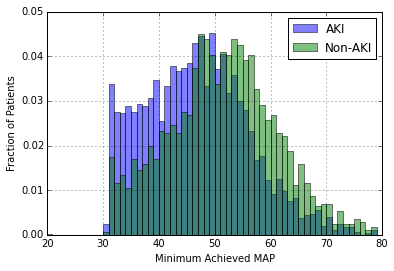

In [10]:
# Look at MAP split between AKI and Non-AKI subsets
bins = np.arange(20,80,1)

aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='AKI',normed=True)
non_aki_dataset['min_map'].hist(alpha=0.5, bins = bins, label='Non-AKI',normed=True)

plt.legend(loc='upper right')
plt.xlabel('Minimum Achieved MAP')
plt.ylabel('Fraction of Patients')
plt.show()

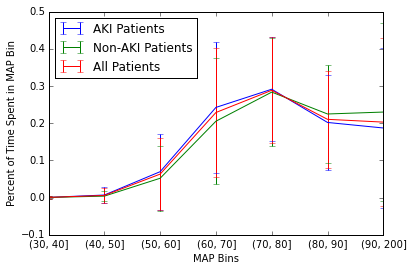

In [11]:
# Plot of percent of time spent within each MAP bin
map_labels = ['(30, 40]','(40, 50]','(50, 60]','(60, 70]','(70, 80]','(80, 90]','(90, 200]']

aki_map_avg = aki_dataset[map_labels].describe()
non_aki_map_avg = non_aki_dataset[map_labels].describe()
all_map_avg = lr_data[map_labels].describe()

ind_avg = 1
ind_std = 2

row = aki_map_avg.iloc[ind_avg]
row.plot(kind='line',yerr=aki_map_avg.iloc[ind_std],label='AKI Patients')

row = non_aki_map_avg.iloc[ind_avg]
row.plot(kind='line',yerr=non_aki_map_avg.iloc[ind_std],label='Non-AKI Patients')

row = all_map_avg.iloc[ind_avg]
row.plot(kind='line',yerr=all_map_avg.iloc[ind_std],label='All Patients')

plt.legend(loc='upper left')
plt.xlabel('MAP Bins')
plt.ylabel('Percent of Time Spent in MAP Bin')

In [17]:
# Organize data for logistic regression

train_cols = lr_data[['age','gender','eth','los','max_lactate','vaso_frac','min_map']]

# Explicitly get dummy variables for categoricals

train_cols['gender'] = pd.Categorical(train_cols['gender'])
gender_dummies = pd.get_dummies(train_cols['gender'], prefix='gender')
train_cols = train_cols.join(gender_dummies.ix[:, 'gender_2':])
del train_cols['gender']
del train_cols['gender_M'] # delete reference group to prevent multicollinearity

train_cols['eth'] = pd.Categorical(train_cols['eth'])
gender_dummies = pd.get_dummies(train_cols['eth'], prefix='eth')
train_cols = train_cols.join(gender_dummies.ix[:, 'eth':])
del train_cols['eth']
del train_cols['eth_WHITE'] # delete reference group to prevent multicollinearity
print train_cols

# Manually add the intercept
train_cols['intercept'] = 1.0

# Do logistic regression
logit = sm.Logit(lr_data['aki'], train_cols)
result = logit.fit()
print result.summary()

                   age      los  max_lactate  vaso_frac    min_map  gender_F  \
icustay_id                                                                     
200003       48.294893   5.8884          5.1   0.222898  52.000000         0   
200033       67.145095  13.8771          1.2   0.029075  49.000000         0   
200063       37.073160  26.7171          4.9   0.078523  42.000000         0   
200087       64.308966   4.2641          2.2   0.237121  51.000000         0   
200109       71.572101  11.3254          1.8   0.090750  52.666698         0   
200131       69.310069   8.2287          1.3   0.000675  51.000000         1   
200143       62.247519  26.7823          1.3   0.019914  57.000000         1   
200166       24.118157  17.6084          4.1   0.338972  50.666698         0   
200210       78.661208  13.4556          7.7   0.682287  50.000000         1   
200220       43.741227  38.1613          4.7   0.000000  53.000000         1   
200229       53.235187  17.5171         

In [22]:
# Get odds ratios
print np.exp(result.params)

age                                  1.003409
los                                  1.049870
max_lactate                          1.049702
vaso_frac                            1.290697
min_map                              0.967876
gender_F                             1.030406
eth_AMERICAN INDIAN/ALASKA NATIVE    0.551938
eth_ASIAN                            0.384298
eth_BLACK/AFRICAN AMERICAN           0.974490
eth_HISPANIC/LATINO                  0.690388
eth_MULTI/OTHER                      0.750915
eth_UNKNOWN                          0.934428
intercept                            3.390322
dtype: float64
